In [149]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize

R = np.random.RandomState(42)

In [301]:
# https://www.youtube.com/watch?v=92-98SYOdlY 
#   - really good intro to gaussian processes

# https://github.com/hyperopt/hyperopt
# https://github.com/Yelp/MOE
# https://ai.google/research/pubs/pub46180
# https://sigopt.com/
# https://www.botorch.org/

# pip3 install scikit-optimize
# pip3 install gpy
# pip3 install gpyopt
# pip3 install botorch

# What is BO?

A framework for optimizing **expensive**, **noisy**, **non-convex**, and **non-differentiable** (in practice) functions.

* Optimal design of experiments (Kirstine Smith 1918)
* Bayesian optimization (Kushner 1961, Mockus 1974)
* Nowadays
  * Active learning
  * Contextual bandits
  * Bayesian nonparametrics
  * Sparse Gaussian Processes

# When to use BO?

* The objective can be evaluated pointwise.
* Gradients are not available.
* Pointwise evaluation is **expensive**.
* The observations may be **noisy**.
* There may be **constraints** that must be learned.
* Constant factors matter.
* There may be useful structure to model.

# How does BO work?

* Replace target function with a cheap proxy function (surrogate).
* Optimize the surrogate function, updating it as we get more points.
* Assumes that the surrogate function is a good model.

The main insight:

Try to use the model to make smart decisions about where to spend expensive evaluation resources.

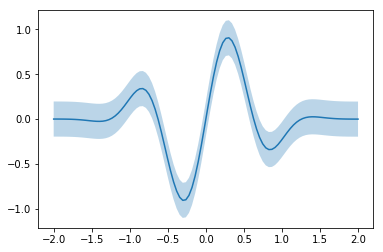

In [370]:
def f(params, noise=0.1):
    x = params[0]
    n = R.normal() * noise
    return (np.sin(5 * x) * (1 - np.tanh(x ** 2)) + n)

x = np.linspace(-2, 2, 100)
y = f([x], noise=0.0)
plt.plot(x, y)
plt.fill_between(x, y - 0.1 * 1.96, y + 0.1 * 1.96, alpha=0.3)

In [381]:
def test():
    global res
    res = gp_minimize(f, [(-2.0, 2.0)], 
                      noise=0.1**2, 
                      n_calls=100)

%timeit -n 1 -r 1 test()

/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/site-packa

33.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


interactive(children=(IntSlider(value=49, description='n', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_graphs(n)>

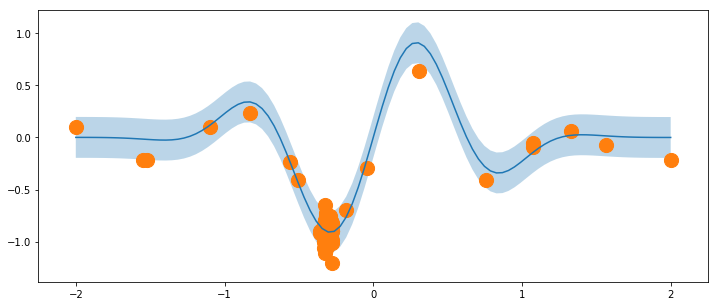

In [382]:
def plot_graphs(n):
    x = np.linspace(-2, 2, 100)
    y = f([x], noise=0.0)
    plt.figure(figsize=(12, 5))
    plt.plot(x, y)
    plt.fill_between(x, y - 0.1 * 1.96, y + 0.1 * 1.96, alpha=0.3)
    plt.scatter(np.array(res.x_iters)[:n,0], res.func_vals[:n], marker='o', s=200)
    yp, ys = res.models[n].predict((x[:,None] + 2) / 4, return_std=True)
    plt.plot(x, yp)
    plt.fill_between(x, yp - ys * 1.96, yp + ys * 1.96, alpha=0.3)
    
interact(plot_graphs, n=(0, 99))

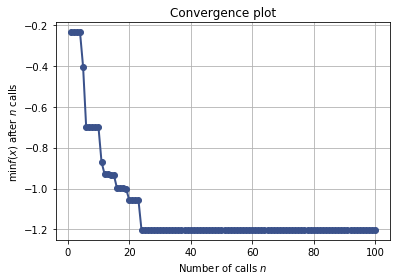

In [383]:
from skopt.plots import plot_convergence
plot_convergence(res)

* Has been successful on a lot of hard problems.
* No free lunch: curse of dimensionality still in effect.
* Can build assumptions in!
* More assumptions -> better priors -> faster optimization.
* You can learn multiple objectives at the same time (need correlations of outputs).

# Freeze-Thaw Bayesian Optimization

* SGD often diverges or doesn't converge well.
* Humans often abort jobs that aren't promising.
* Freeze-Thaw bayesian optimization tries to do the same (Swersky, Snoek & Adams 2015).
* Project outcome and only finish promising runs.
* Helps a lot if there are a lot of bad configurations.

# A related setting: bandits

A classical problem:

* Each bandit (a slot machine) has K arms, each with an association reward distribution.
* On each round, you pull one arm and observe the reward.
* Your goal is to either minimize cumulative regret or find the best arm as quickly as possible.
* Infinite number of arms = a function in one parameter.

Compare to A/B testing!

# A related setting: reinforcement learning

* _Agents_ take actions in an environment.
* The goal is to maximize some notion of cumulative reward. 
* You don't observe the reward immediately.

# Optimization as a service

* Google Vizier
* SigOpt

# Gaussian processes

* Non-parametric model (infinite number of parameters).
* [This video](https://www.youtube.com/watch?v=92-98SYOdlY) is a great introduction to Gaussian Processes.

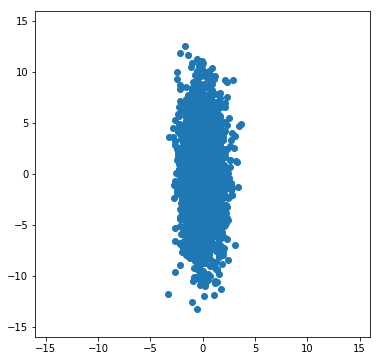

In [303]:
data = R.normal(loc=[0,0], scale=[1,4], size=(3000, 2))
plt.figure(figsize=(6, 6))
plt.xlim([0-16,0+16])
plt.ylim([0-16,0+16])
plt.scatter(data[:,0], data[:,1])

In [226]:
A = np.pi*45/180
M = [[np.cos(A), -np.sin(A)], [np.sin(A), np.cos(A)]]
M = np.array(M)
np.einsum('ij,j', M, [1,0])

array([0.70710678, 0.70710678])

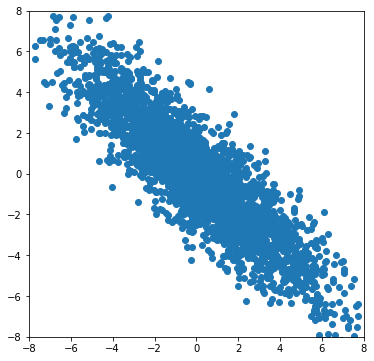

In [304]:
data = R.normal(loc=[0,0], scale=[1,4], size=(3000, 2))
data = np.einsum('ij,kj->ki', M, data)
plt.figure(figsize=(6, 6))
plt.xlim([0-8,0+8])
plt.ylim([0-8,0+8])
plt.scatter(data[:,0], data[:,1])

[[ 8.27835524 -7.36591873]
 [-7.36591873  8.38073372]]


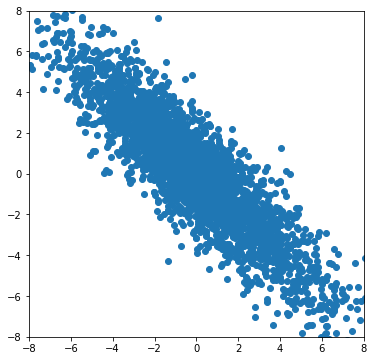

In [305]:
print(np.cov(data.T))
data = R.multivariate_normal(mean=np.zeros(2), cov=np.cov(data.T), size=3000)
plt.figure(figsize=(6, 6))
plt.xlim([0-8,0+8])
plt.ylim([0-8,0+8])
plt.scatter(data[:,0], data[:,1])

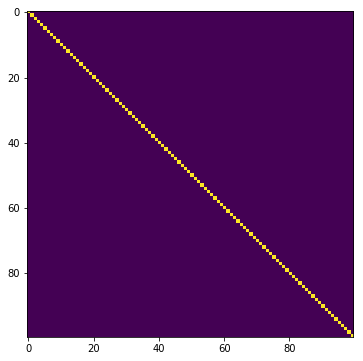

In [325]:
S = np.arange(100)[:,None] - np.arange(100)[None,:]
S = np.exp(-S ** 2 / (2 * 0.01 ** 2))
plt.figure(figsize=(6, 6))
plt.imshow(S)

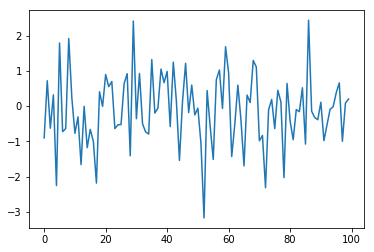

In [328]:
data = R.multivariate_normal(mean=np.zeros(100), cov=S, size=1)[0]
plt.plot(np.arange(100), data)

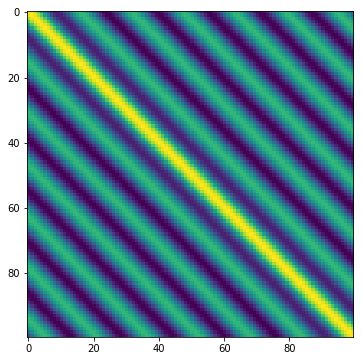

In [333]:
S = np.arange(100)[:,None] - np.arange(100)[None,:]
S = np.cos(-S / 5) ** 2 + np.exp(-S ** 2 / (2 * 5 ** 2)) / 2
plt.figure(figsize=(6, 6))
plt.imshow(S);
plt.show();

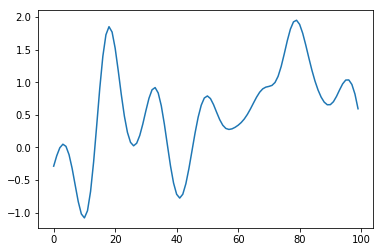

In [334]:
data = R.multivariate_normal(mean=np.zeros(100), cov=S, size=1)[0]
plt.plot(np.arange(100), data)

In [291]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

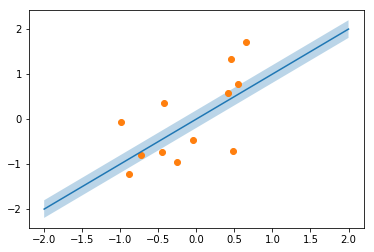

In [352]:
def f(params, noise=1.0):
    x = params[0]
    n = R.normal() * noise
    return x + n # (np.sin(5 * x) * (1 - np.tanh(x ** 2)) + n)

x = np.linspace(-2, 2, 100)
y = f([x], noise=0.0)
plt.plot(x, y)
plt.fill_between(x, y - 0.1 * 1.96, y + 0.1 * 1.96, alpha=0.3)

xs = R.uniform(size=12) * 2 - 1
ys = [f([x]) for x in xs]
plt.scatter(xs, ys)

In [367]:
m = GaussianProcessRegressor(kernel=RBF(0.03) + WhiteKernel(1e-3))
m.fit(xs[:,None], ys)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=0.03) + WhiteKernel(noise_level=0.001),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

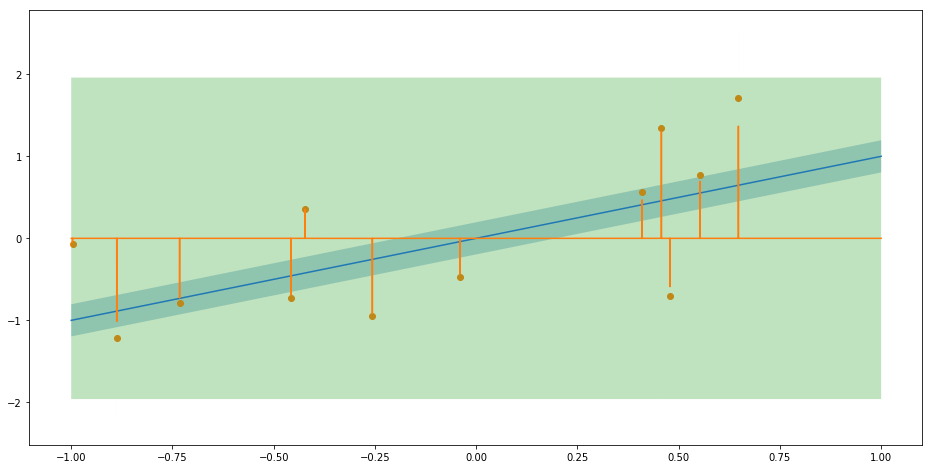

In [368]:
x = np.linspace(-1, 1, 100000)
y = f([x], noise=0.0)
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.fill_between(x, y - 0.1 * 1.96, y + 0.1 * 1.96, alpha=0.3)

plt.scatter(xs, ys)

y1, s1 = m.predict(x[:, None], return_std=True)
plt.plot(x, y1)
plt.fill_between(x, y1 - s1 * 1.96, y1 + s1 * 1.96, alpha=0.3)